# Credit Card Fraud

# Classifying Credit Card Fraud -- Part I

The goal of this project is to predict fraudulent credit card transations using the Credit Card Fraud data in Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud/data). The predictors have been anonymized by PCA.

The data in this data set are imbalanced. I.e., there are about 500 fraudulent transactions vs. 300,000 non-fraudulent transactions (a rate of 0.2%). Correctly classifying fraudulent transactions becomes more challenging because typical classifiers can achieve 99.8% accuracy by classifying every transaction as non-fraudulent.

For the sake of decision-making, this project will use the following implicit
weights:

Cost of a False Negative = 4

Cost of a False Positive = 1

We are willing to falsely flag 4 transactions as fraudulent in order to catch 1.
That is, we are willing to accept a Positive Predictive Value (PPV) as low as 20%.


There is an initial analysis in R. This script picks up where the R version left
off, as computational speed was a limiting factor. These Jupyter Notebooks are more complete.

In [1]:
import os
os.getcwd()


'C:\\Users\\alexa\\Documents\\Python\\Credit_fraud-kaggle'

## Read in Data

In [2]:
# Import libraries; set a seed for all models
import random
rand_state = 123456
random.seed(rand_state)
from Credit_Fraud_functions import *

In [3]:
credit_1 = pd.read_csv('Data/creditcard_1.csv')
credit_2 = pd.read_csv('Data/creditcard_2.csv')
credit = credit_1.append(credit_2, ignore_index=True)
del credit_1, credit_2    # Free up some memory

There is one entry missing. It's from a non-fraud case so I'm just going to drop it.

In [4]:
print(credit[credit.isnull().any(axis=1)])
credit = credit.dropna()


        Time        V1        V2        V3        V4       V5        V6  \
153758   NaN -1.408633 -1.624698  2.547742  0.385672  0.50279  0.507195   

              V7        V8        V9  ...         V21       V22       V23  \
153758 -1.744431  0.760594  3.001704  ...    0.217641  0.758247  0.281254   

             V24       V25      V26       V27       V28  Amount  Class  
153758  0.736608 -0.741402  0.25535  0.141944  0.228167    49.5      0  

[1 rows x 31 columns]


### Some Exploratory data analysis. 

These data are composed of anonymized variables that have been reduced by PCA. For that reason descriptive stats aren’t as important to us as they would normally be, since we have absolutelyno way of interpreting them.

There are two variables that are not PCA transformed-- `Time` and `Amount`


Here is `Time`:

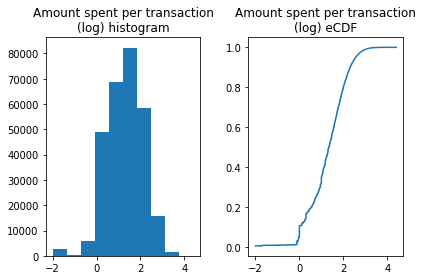

In [5]:
hist_ecdf(np.log10(credit['Amount'] + 0.01), 'Amount spent per transaction (log)')

The amount spent is log-normally distributed. Most transactions are very small, but some are very large. Larger transactions may(?) be more associated with fraud.


`Time` represents seconds since 12AM (time 0), spanning over a 48 hour period.

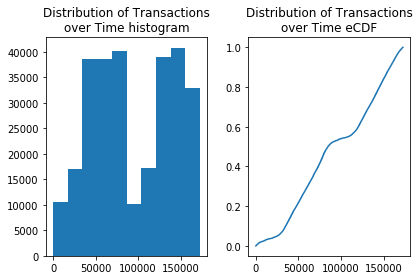

In [6]:
hist_ecdf(credit['Time'], 'Distribution of Transactions over Time')

Create a new variable that converts these time diffs to hour of the day (as floats)

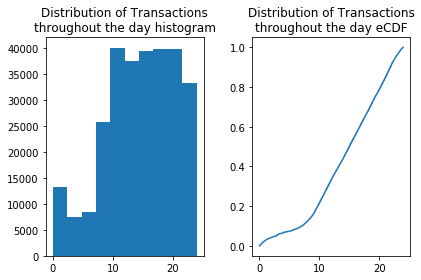

In [7]:
mask = credit['Time'] > 86400
credit['time_of_day'] = np.where(credit['Time'] > 86400,
                                 (credit['Time'] - 86400) / 3600,
                                 credit['Time'] / 3600)
credit = credit.drop('Time', axis=1)

hist_ecdf(credit['time_of_day'], 'Distribution of Transactions throughout the day')

## Data Partitioning

Split the data into train (70%), dev, and test sets (15% each)

In [8]:
from sklearn.model_selection import train_test_split

credit_train, temp = train_test_split(credit, test_size=0.3, stratify=credit['Class'])
credit_dev, credit_test = train_test_split(temp, test_size=0.5, stratify=temp['Class'])

# Split response (y) variable from predictors (X)
credit_train_x = credit_train.drop('Class', 1)
credit_train_y = credit_train['Class']

credit_dev_x = credit_dev.drop('Class', 1)
credit_dev_y = credit_dev['Class']

credit_test_x = credit_test.drop('Class', 1)
credit_test_y = credit_test['Class']


## Sampling Techniques for Imbalanced Classes

These data are highly imbalanced. Only 0.2% of observations are fraud. The main goal of this Notebook is to test out some different sampling methods and see how they perform.

To limit computational resources, I'm only going to use a lasso logistic regression for each in order to see which produce the best (least awful) results. I will carry over the most promising sampling methods into future analyses and train different types of classification models.



### Summary (Spoilers)

***

#### Procedure
* The sampling techniques are *undersampling, oversampling, SMOTE (borderline2), SMOTE (SVM), ADASYN*, and No Sampling. 

* Data from each sampling technique were fitted by lasso logistic regression. Precision and recall are the main metrics of model success. 

* While I am operating under the assumption that False Negatives are 4x worse than False Positives, I have not explicitly coded weights here as maximizing these metrics was not the explicit goal of this notebook.

* For all of the sampling techniques except for *undersampling*, I've reduced the starting pool of non-fraud observations to 40,000 to speed up computation.


#### Results

* No sampling produced the best precision and recall in the development set. *SMOTE (SVM)* performed second best. *SMOTE (borderline2)* had success compared to undersampling, but still performed fairly poorly. Undersampling and ADASYN did not perform very well.

* I will move forward and try out other models on data without sampling, SMOTE (SVM) and SMOTE (borderline)

#### Other Findings

* In all models, the first 20% of cases could be detected with perfect precision. The next 60% of cases had precision ~80%. The remaining 20% of cases were much more difficult for the logistic regression to classify. At this time I don't know if its because the observations are very difficult to classify or if it is a limitation in the logistic regression.

* Each logistic regression produced different rankings for variable importance, but the following were generally important: V14, V4, V10, V12

### Undersampling

In [9]:
# Generate undersampled data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=rand_state, replacement=False)
credit_train_x_undersampled, credit_train_y_undersampled = rus.fit_sample(credit_train_x, credit_train_y)
print(credit_train_x_undersampled.shape)

(688, 30)


In [10]:
# Perform a L1 penalized logistics regression grid search for lambda
param_grid = [{'C': [0.001, 0.0015, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1']}]
scores = ['f1_macro']

In [11]:
# This function is a simple wrapper around sk-learn functions (Credit_Fraud_functions.py)
# It performs a grid search using provided parameters and prints the results.
# Prints training metrics for each combination of parameters and tests the
# best training model against the dev set.
clf_log_under = auto_grid_search_clf(x_train=credit_train_x_undersampled,
                                     y_train=credit_train_y_undersampled,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 1, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.3462 (+/-0.0647) for {'C': 0.001, 'penalty': 'l1'}
0.8377 (+/-0.0723) for {'C': 0.0015, 'penalty': 'l1'}
0.9213 (+/-0.0394) for {'C': 0.01, 'penalty': 'l1'}
0.9374 (+/-0.0394) for {'C': 0.1, 'penalty': 'l1'}
0.9389 (+/-0.0470) for {'C': 1, 'penalty': 'l1'}
0.9375 (+/-0.0413) for {'C': 10, 'penalty': 'l1'}
0.9360 (+/-0.0277) for {'C': 100, 'penalty': 'l1'}
0.9360 (+/-0.0277) for {'C': 1000, 'penalty': 'l1'}
0.9375 (+/-0.0281) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     42647
          1       0.04      0.92      0.08        74

avg / total       1.00      0.96      0.98     42721



#### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(credit_dev_y, clf_log_under.predict(credit_dev_x))

array([[41156,  1491],
       [    6,    68]], dtype=int64)

#### Training F-1 Score vs. Lambda

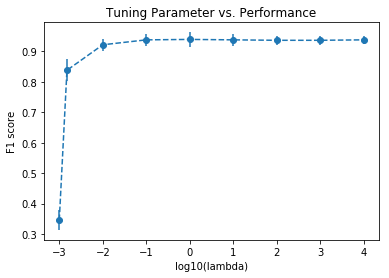

In [13]:
# This is a wrapper around some matplotlib code to reduce repetition.
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_under.cv_results_['mean_test_score'],
                 error=clf_log_under.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

#### Variable Importance 

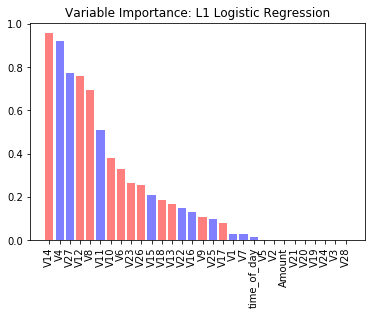

In [14]:
# Plot the coefficients
variable_names = pd.Series(credit_train_x.columns.values)
plot_varimp_logistic(clf_log_under, variable_names)

#### Precision vs. Recall Curve

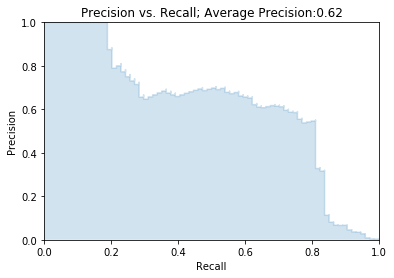

In [15]:
plot_precision_recall(clf_log_under.decision_function(credit_dev_x), credit_dev_y)

#### Naive Oversampling

In [16]:
temp = credit_train[credit_train['Class'] == 1]
temp2 = credit_train[credit_train['Class'] == 0]
credit_train_cut = temp2.sample(n = 40000).append(temp, ignore_index = True)

credit_train_cut_x = credit_train_cut.drop('Class', 1)
credit_train_cut_y = credit_train_cut['Class']

In [17]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=rand_state)
credit_train_x_oversampled, credit_train_y_oversampled = \
    ros.fit_sample(credit_train_cut_x, credit_train_cut_y)

print(credit_train_x_oversampled.shape)

(80000, 30)


In [18]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_over = auto_grid_search_clf(x_train=credit_train_x_oversampled,
                                     y_train=credit_train_y_oversampled,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 10, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.9386 (+/-0.0057) for {'C': 0.001, 'penalty': 'l1'}
0.9436 (+/-0.0045) for {'C': 0.0015, 'penalty': 'l1'}
0.9474 (+/-0.0051) for {'C': 0.01, 'penalty': 'l1'}
0.9482 (+/-0.0032) for {'C': 0.1, 'penalty': 'l1'}
0.9505 (+/-0.0036) for {'C': 1, 'penalty': 'l1'}
0.9506 (+/-0.0038) for {'C': 10, 'penalty': 'l1'}
0.9506 (+/-0.0038) for {'C': 100, 'penalty': 'l1'}
0.9504 (+/-0.0036) for {'C': 1000, 'penalty': 'l1'}
0.9504 (+/-0.0036) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     42647
          1       0.07      0.91      0.13        74

avg / total       1.00      0.98      0.99     42721



In [50]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_over.predict(credit_dev_x))

array([[41765,   882],
       [    7,    67]], dtype=int64)

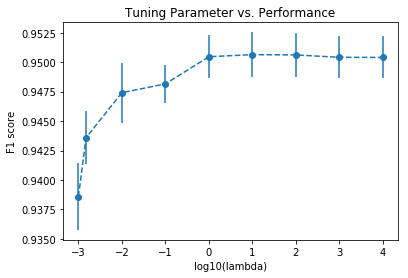

In [20]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_over.cv_results_['mean_test_score'],
                 error=clf_log_over.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

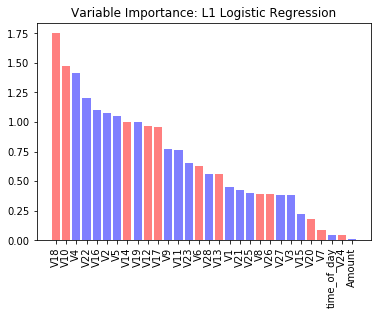

In [21]:
## Plot variable importance
plot_varimp_logistic(clf_log_over, variable_names)

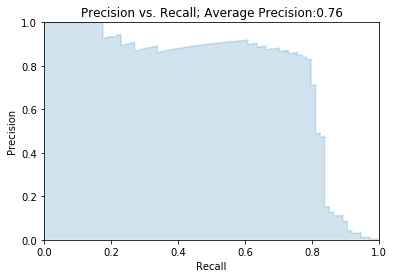

In [22]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_over.decision_function(credit_dev_x), credit_dev_y)

#### SMOTE Sampling -- Borderline2

SMOTE is synthetic minority oversmapling technique. It is an oversampling technique, but rather than replicating the minority class it creates new (synthetic) observations by interpolating values from existing observations.

The borderline method only uses samples that are 'in danger' (e.g., is classified correctly but has nearest neighbours of a different class) to generate the new observations. This is in contrast to default SMOTE, which may interpolate excessively between very easy 'inliers' (resulting in over-confidence in the decision boundary) and/or interpolate between inliers and outliers (resulting in a large influence of noise data)

In [23]:
from imblearn.over_sampling import SMOTE

# Using the cut data with the original ~300,000 negative examples cut down
# to 40,000.
credit_train_x_smote, credit_train_y_smote = \
    SMOTE(kind='borderline2').fit_sample(credit_train_cut_x, credit_train_cut_y)
print(credit_train_x_smote.shape)


(79999, 30)


In [24]:

# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_smote = auto_grid_search_clf(x_train=credit_train_x_smote,
                                     y_train=credit_train_y_smote,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 1, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.9551 (+/-0.0128) for {'C': 0.001, 'penalty': 'l1'}
0.9597 (+/-0.0122) for {'C': 0.0015, 'penalty': 'l1'}
0.9703 (+/-0.0139) for {'C': 0.01, 'penalty': 'l1'}
0.9724 (+/-0.0130) for {'C': 0.1, 'penalty': 'l1'}
0.9728 (+/-0.0134) for {'C': 1, 'penalty': 'l1'}
0.9728 (+/-0.0134) for {'C': 10, 'penalty': 'l1'}
0.9728 (+/-0.0134) for {'C': 100, 'penalty': 'l1'}
0.9728 (+/-0.0134) for {'C': 1000, 'penalty': 'l1'}
0.9728 (+/-0.0134) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     42647
          1       0.10      0.85      0.17        74

avg / total       1.00      0.99      0.99     42721



In [49]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_smote.predict(credit_dev_x))


array([[42047,   600],
       [   11,    63]], dtype=int64)

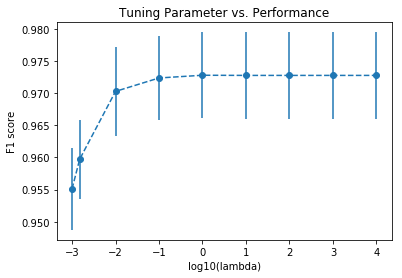

In [26]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_smote.cv_results_['mean_test_score'],
                 error=clf_log_smote.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

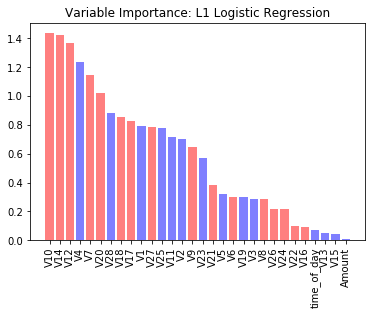

In [27]:
## Plot variable importance
plot_varimp_logistic(clf_log_smote, variable_names)

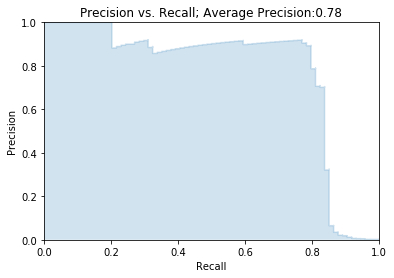

In [28]:

## Plot precision vs. recall curve
plot_precision_recall(clf_log_smote.decision_function(credit_dev_x), credit_dev_y)

#### SMOTE Sampling -- SVM

Uses the same SMOTE algorithm, but decides which samples to interpolate between using an SVM. The result is that the majority of samples are synthesized between observations near the margin.

In [29]:
credit_train_x_smote_svm, credit_train_y_smote_svm = \
    SMOTE(kind='svm').fit_sample(credit_train_cut_x, credit_train_cut_y)
print(credit_train_x_smote_svm.shape)

(80000, 30)


In [30]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_smote_svm = auto_grid_search_clf(x_train=credit_train_x_smote_svm,
                                     y_train=credit_train_y_smote_svm,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 1000, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.9684 (+/-0.0250) for {'C': 0.001, 'penalty': 'l1'}
0.9719 (+/-0.0236) for {'C': 0.0015, 'penalty': 'l1'}
0.9796 (+/-0.0185) for {'C': 0.01, 'penalty': 'l1'}
0.9846 (+/-0.0121) for {'C': 0.1, 'penalty': 'l1'}
0.9853 (+/-0.0113) for {'C': 1, 'penalty': 'l1'}
0.9853 (+/-0.0113) for {'C': 10, 'penalty': 'l1'}
0.9853 (+/-0.0112) for {'C': 100, 'penalty': 'l1'}
0.9853 (+/-0.0113) for {'C': 1000, 'penalty': 'l1'}
0.9853 (+/-0.0112) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.99      1.00     42647
          1       0.17      0.85      0.29        74

avg / total       1.00      0.99      1.00     42721



In [48]:

## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_smote_svm.predict(credit_dev_x))

array([[42346,   301],
       [   11,    63]], dtype=int64)

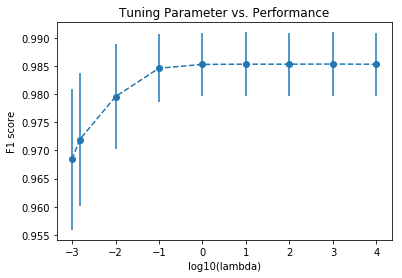

In [32]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_smote_svm.cv_results_['mean_test_score'],
                 error=clf_log_smote_svm.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')


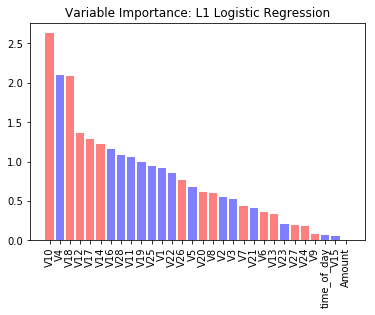

In [33]:
## Plot variable importance
plot_varimp_logistic(clf_log_smote_svm, variable_names)

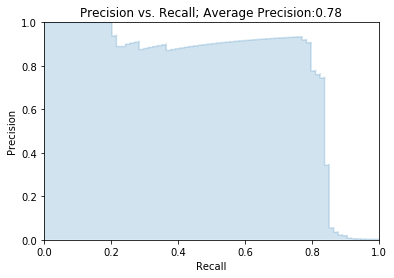

In [34]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_smote_svm.decision_function(credit_dev_x), credit_dev_y)

#### ADASYN Sampling

Adaptive Synthetic Sampling uses the same algorithm as SMOTE to generate new samplees, but it uses a KNN classifier--synthetic observations are generated near observations that are misclassified by the KNN model.

In [35]:
from imblearn.over_sampling import ADASYN

credit_train_x_adasyn, credit_train_y_adasyn = \
    ADASYN().fit_sample(credit_train_cut_x, credit_train_cut_y)
print(credit_train_x_adasyn.shape)


(80019, 30)


In [36]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_adasyn = auto_grid_search_clf(x_train=credit_train_x_adasyn,
                                     y_train=credit_train_y_adasyn,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 10, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.8945 (+/-0.0533) for {'C': 0.001, 'penalty': 'l1'}
0.8994 (+/-0.0513) for {'C': 0.0015, 'penalty': 'l1'}
0.9119 (+/-0.0455) for {'C': 0.01, 'penalty': 'l1'}
0.9150 (+/-0.0446) for {'C': 0.1, 'penalty': 'l1'}
0.9158 (+/-0.0443) for {'C': 1, 'penalty': 'l1'}
0.9159 (+/-0.0441) for {'C': 10, 'penalty': 'l1'}
0.9159 (+/-0.0442) for {'C': 100, 'penalty': 'l1'}
0.9159 (+/-0.0442) for {'C': 1000, 'penalty': 'l1'}
0.9157 (+/-0.0442) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     42647
          1       0.03      0.91      0.07        74

avg / total       1.00      0.96      0.98     42721



In [46]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_adasyn.predict(credit_dev_x))

array([[40748,  1899],
       [    7,    67]], dtype=int64)

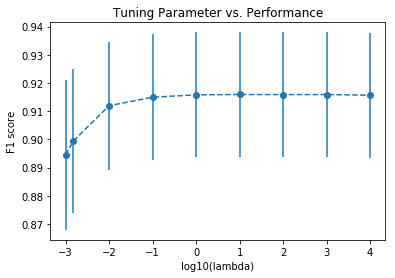

In [38]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_adasyn.cv_results_['mean_test_score'],
                 error=clf_log_adasyn.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

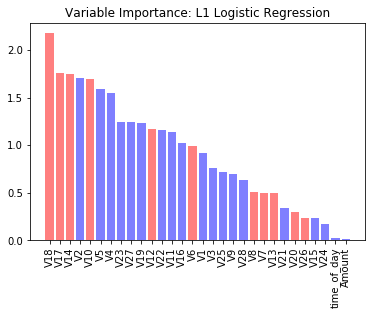

In [39]:
## Plot variable importance
plot_varimp_logistic(clf_log_adasyn, variable_names)

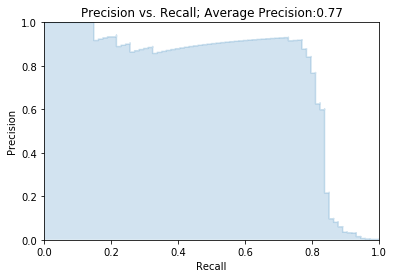

In [40]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_adasyn.decision_function(credit_dev_x), credit_dev_y)

#### No Sampling

How does no sampling compare to some of the more sophisticated sampling techniques?

I'm still going to apply some undersampling to the majority class for computational purposes. I'm keeping 40,000 non-event observations.

In [41]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_nosample = auto_grid_search_clf(x_train=credit_train_cut_x,
                                     y_train=credit_train_cut_y,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

Best Parameters
{'C': 0.1, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.6546 (+/-0.0648) for {'C': 0.001, 'penalty': 'l1'}
0.7082 (+/-0.0933) for {'C': 0.0015, 'penalty': 'l1'}
0.9026 (+/-0.0534) for {'C': 0.01, 'penalty': 'l1'}
0.9264 (+/-0.0386) for {'C': 0.1, 'penalty': 'l1'}
0.9258 (+/-0.0408) for {'C': 1, 'penalty': 'l1'}
0.9253 (+/-0.0371) for {'C': 10, 'penalty': 'l1'}
0.9253 (+/-0.0371) for {'C': 100, 'penalty': 'l1'}
0.9253 (+/-0.0371) for {'C': 1000, 'penalty': 'l1'}
0.9253 (+/-0.0371) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     42647
          1       0.89      0.78      0.83        74

avg / total       1.00      1.00      1.00     42721



In [47]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_nosample.predict(credit_dev_x))

array([[42640,     7],
       [   16,    58]], dtype=int64)

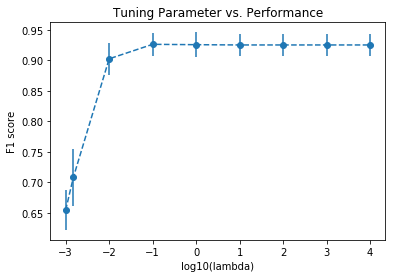

In [43]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_nosample.cv_results_['mean_test_score'],
                 error=clf_log_nosample.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

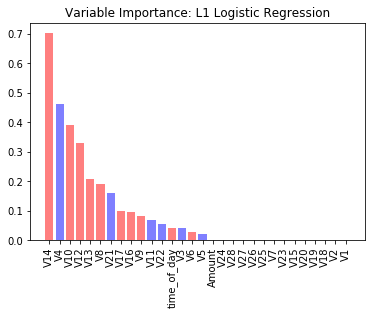

In [44]:
## Plot variable importance
plot_varimp_logistic(clf_log_nosample, variable_names)

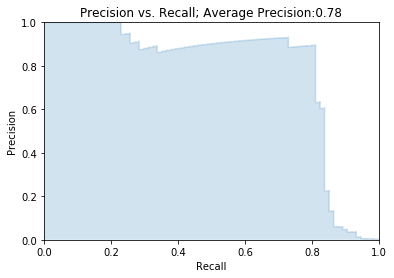

In [45]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_nosample.decision_function(credit_dev_x), credit_dev_y)

### Summary

***

#### Objectives
The goal of this Notebook was to identify which sampling techniques work well for these data.


#### Procedure
* The sampling techniques are *undersampling, oversampling, SMOTE (borderline2), SMOTE (SVM), ADASYN*, and No Sampling. 

* Data from each sampling technique were fitted by lasso logistic regression. Precision and recall are the main metrics of model success. 

* While I am operating under the assumption that False Negatives are 4x worse than False Positives, I have not explicitly coded weights here as maximizing these metrics was not the explicit goal of this notebook.

* For all of the sampling techniques except for *undersampling*, I've reduced the starting pool of non-fraud observations to 40,000 to speed up computation.


#### Results

* No sampling produced the best precision and recall in the development set. *SMOTE (SVM)* performed second best. *SMOTE (borderline2)* had success compared to undersampling, but still performed fairly poorly. Undersampling and ADASYN did not perform very well.

* I will move forward and try out other models on data without sampling, SMOTE (SVM) and SMOTE (borderline)

#### Other Findings

* In all models, the first 20% of cases could be detected with perfect precision. The next 60% of cases had precision ~80%. The remaining 20% of cases were much more difficult for the logistic regression to classify. At this time I don't know if its because the observations are very difficult to classify or if it is a limitation in the logistic regression.

* Each logistic regression produced different rankings for variable importance, but the following were generally important: V14, V4, V10, V12

The analysis is continued in [Credit-Fraud_2.ipynb](https://github.com/pan-alex/Credit_Fraud-kaggle/blob/master/Credit_Fraud_2.ipynb).